# Visualization

Here we calculate the values used for further analysis in the other notebooks. These will be visualized through Word Clouds and others.

## Similarity 

When we examine the similarity of two tweets, we are not particularly interested in the 
lexical similarity, where two tweets are deemed very similar if they contain large, identical sequences of characters. Instead, we are interested in the content based similarity. 

The idea is based on chapter 9.26: Recommending Items to Users Based on Content. In general terms, this includes finding similar documents based on occurrences of many important words in both documents, as follows:

- Represent documents with TF-IDF vectors (of the 15 most important words (approx 1/5 twitter length))

- Compute jaccard similarity between the vectors

- Use minhashing as data for LSH

- Use LSH to find the pairs of documents that are similar in the sense of
sharing many common keywords.

In [ ]:
!python -m pip install tqdm requests nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
!pip install simplemma

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 29.9 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from IPython.display import display
import pandas as pd
import requests
import re
import simplemma #use simplemma instead of nltk.WordNetLemmatizer() 
from urllib.request import urlopen
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
#from fa2 import ForceAtlas2
from scipy import stats
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import io
from tqdm import tqdm
from heapq import nlargest 
import ast
import seaborn as sns
sns.set()

In [ ]:
giant_df = pd.read_csv("Data/Giant.csv")
#display(giant_df.head())

In [ ]:
%load_ext autoreload
%autoreload 2
!python -m pip install -r requirements.txt
from utils.initialization import *


# med mrjob
# names, party and twitter id
from Data.twitter_ids import twitter_ids
data = pd.DataFrame(columns=['name', "party", 'twitter_id'])
i = 0
for party in twitter_ids:
    for person in twitter_ids[party]:
        data.loc[i, :] = [person, party, twitter_ids[party][person]]
        i += 1

# tweets
filename = "Data/cleaned_data.csv"
if not os.path.exists(filename):
    os.system(f"python utils/clean_data_mrjob.py Data/tweets > Data/tmp_cleaned_data.txt")
    data_ = pd.DataFrame(columns=["name", "tweets"])
    with open("Data/tmp_cleaned_data.txt", "rb") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            line = eval(line.decode())
            data_.loc[i,"name"] = list(line.keys())[0]
            data_.loc[i, "tweets"] = list(line.values())[0]
    data_.to_csv(filename, index = False)

data_ = pd.read_csv(filename)
data = data.merge(data_)
data.tweets = [eval(t) for t in data.tweets]
data["tokens"] = [[w for w in word_tokenize(" ".join(data["tweets"][i])) if w.isalnum()] for i in range(len(data))]
data

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 KB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 KB 73.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.8/661.8 KB 88.0 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=4b56d6b4cc301998ea58bb2528b3f2c45cf7b9a9121639544b0a7c0e2e095831
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is al

,name,party,twitter_id,tweets,tokens
0,magnus_heunicke,socialdemokratiet,22695562,[afsætter året styrke hjælpen børn pårørende a...,"[afsætter, året, styrke, hjælpen, børn, pårøre..."
1,nicolai_wammen,socialdemokratiet,2803948786,[dage siden sagde nyt ejendomsvurderingssystem...,"[dage, siden, sagde, nyt, ejendomsvurderingssy..."
2,mattias_tesfaye,socialdemokratiet,546254893,[this is literally the same logic many th c am...,"[this, is, literally, the, same, logic, many, ..."
3,jakob_ellemann,venstre,155584627,[tide få fleksibel genåbning vores børn ældre ...,"[tide, få, fleksibel, genåbning, vores, børn, ..."
4,soren_gade,venstre,975064362359623680,[kære marianne synes burde læse lovforslaget i...,"[kære, marianne, synes, burde, læse, lovforsla..."
5,sophie_lohde,venstre,44611200,[flertallet veto dermed røde partier stort set...,"[flertallet, veto, dermed, røde, partier, stor..."
6,lars_lokke,moderaterne,26201346,[mon ikke sjov form argumentation mangler lidt...,"[mon, ikke, sjov, form, argumentation, mangler..."
7,jacob_mark,sf,2373406198,[slår fast syvtommersøm kom så godt igennem fo...,"[slår, fast, syvtommersøm, kom, så, godt, igen..."
8,pia_dyhr,sf,65025162,"[stemmer nok selvom synes gør godt klaus, brug...","[stemmer, nok, selvom, synes, gør, godt, klaus..."
9,kirsten_andersen,sf,235646319,[arbejde få medarbejdere ser virkeligheden sun...,"[arbejde, få, medarbejdere, ser, virkeligheden..."


- Cleaning

In [ ]:
# Tokenize and clean tweets
STOPWORDS = nltk.corpus.stopwords.words('danish') + ["http"]

def clean_tweet(tweet):
    tokensraw = word_tokenize(tweet) #get tokens 
    tokens = [word.lower() for word in tokensraw if word.isalnum()] #only get words and numbers
    tokens = [simplemma.lemmatize(t, lang='da') for t in tokens]
    tokens = [w for w in tokens if w.lower() not in STOPWORDS] #remove stopwords
    return tokens

In [ ]:
giant_df['CT'] = giant_df['Tweets']
for w in range(len(giant_df)):
    giant_df['CT'][w] = ' '.join(giant_df['CT'][w])
    giant_df['CT'][w] = clean_tweet(giant_df['Tweets'][w])
   

In [ ]:
giant_df.head()

,Party,Person,Tweets,CT
0,socialdemokratiet,magnus_heunicke,"['promises made promises kept', 'covidsmitten ...","[made, promises, kept, falde, blandt, ældre, D..."
1,socialdemokratiet,nicolai_wammen,['vej spændende aften gode kollegaer god valga...,"[spænde, aften, gode, kollega, god, valgaften,..."
2,socialdemokratiet,mattias_tesfaye,"['nytår ps vandt', 'liekaas fremragende filmen...","[ps, vinde, fremragende, film, fremragende, se..."
3,venstre,jakob_ellemann,['fesagen skadet danmarks efterretningstjenest...,"[skade, Danmark, efterretningstjeneste, lad, d..."
4,venstre,soren_gade,"['snothvalpen ved grimmebriller', 'sagt lige s...","[ved, grimmebriller, lige, smide, ble, dkpol, ..."


- Compute TF-IDF vectors

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, max_features=5000)
X = vectorizer.fit_transform(giant_df.CT.apply(lambda x: " ".join(x)))
X

<36x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 50216 stored elements in Compressed Sparse Row format>

In [ ]:
df = pd.DataFrame(X.todense())


In [ ]:
!pip install datasketch==1.5.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 KB 19.3 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
from datasketch import MinHash, MinHashLSH, LeanMinHash

set3 = set(['nordjysk',
 'krage',
 'forbryder',
 'tdf',
 'till',
 'flamme',
 'before',
 'kompoldk',
 'lærling',
 'rudersdal',
 'spærregrænse',
 'maks',
 'jernbane',
 'enmillionstemmer',
 'kommissær',
 'city',
 'grønlandsk',
 'efforts',
 'hkh',
 'partnership',
 'continue',
 'security',
 'want',
 'open',
 'meet',
 'visit',
 'marienborg'])
set2 = set(['isil',
 'socdem',
 'victims',
 'boligskat',
 'skattestop',
 'keep',
 'politiskole',
 'politifolk',
 'dkpolitik',
 'jerusalem',
 'parisaftalen',
 'privatskole',
 'spade',
 'samuelsen',
 'ballade',
 'hej',
 'stormagt',
 'strasbourg'])
set1 = set(['isil',
 'socdem',
 'victims',
 'boligskat',
 'skattestop',
 'keep',
 'politiskole',
 'politifolk',
 'dkpolitik',
 'jerusalem',
 'parisaftalen',
 'privatskole',
 'spade',
 'samuelsen',
 'ballade',
 'hej',
 'stormagt',
 'strasbourg',
 'partnership',
 'continue',
 'security'])

m1 = MinHash(num_perm=128)
m2 = MinHash(num_perm=128)
m3 = MinHash(num_perm=128)
for d in set1:
    m1.update(d.encode('utf8'))
for d in set2:
    m2.update(d.encode('utf8'))
for d in set3:
    m3.update(d.encode('utf8'))

# Create LSH index
lsh = MinHashLSH(threshold=0.5, num_perm=128)
lsh.insert("m2", m2)
lsh.insert("m3", m3)
result = lsh.query(m1)
print("Approximate neighbours with Jaccard similarity > 0.5", result)

Approximate neighbours with Jaccard similarity > 0.5 ['m2']


In [ ]:
m1.jaccard(m3)

0.0625

In [ ]:
m1.jaccard(m2)


0.8828125

In [ ]:
# According to the book (9.2.2) we can get the n most important (highest tfidf score) words PER document and treat them as a set
# (unlike cosine similarity that treats the vectors with 0s and 1s for each time a word appears in both documents)
#https://www.analyticsvidhya.com/blog/2021/12/how-to-extract-key-phrases-using-tfidf-with-python/

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True, max_df=0.25,max_features=500)
vectors = vectorizer.fit_transform(giant_df.CT.apply(lambda x: " ".join(x)))



In [ ]:
dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}


In [ ]:
tfidf_vectors = []  # all deoc vectors by tfidf
for row in vectors:
  tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)})
print("number of documents",len(tfidf_vectors), "the dictionary of document 1", tfidf_vectors[0].keys())

number of documents 36 the dictionary of document 1 dict_keys(['nordjysk', 'krage', 'forbryder', 'tdf', 'till', 'flamme', 'before', 'kompoldk', 'lærling', 'rudersdal', 'spærregrænse', 'maks', 'jernbane', 'enmillionstemmer', 'kommissær', 'city', 'grønlandsk', 'efforts', 'hkh', 'partnership', 'continue', 'security', 'want', 'open', 'meet', 'visit', 'marienborg', 'challenges', 'twitterhjerne', 'common', 'kviklån', 'slappe', 'visitation', 'slagelse', 'chauffør', 'underholdning', 'policy', 'close', 'silkeborg', 'aabenraa', 'really', 'speciale', 'dkaid', 'medlemsland', 'karantæne', 'council', 'formidle', 'hvidovre', 'livskvalitet', 'rengøring', 'thank', 'skoletid', 'prime', 'dksocial', 'decentral', 'met', 'cph', 'rvlm', 'colleagues', 'behind', 'næver', 'vaccineproduktion', 'demens', 'schengen', 'testcenter', 'özlem', 'ældreminister', 'frivillighed', 'opspore', 'inddæmning', 'inddæmme', 'udbrud', 'arbejdslyst', 'synes', 'organdonation', 'spiller', 'ishøj', 'kanon', 'olympics', 'fuldkommen', '

In [ ]:
giant_df['TFIDF_Words'] = [list(tfidf_vectors[i].keys()) for i in range(len(giant_df))]

In [ ]:
giant_df['TFIDF_Words'].iloc[1]

['isil',
 'socdem',
 'victims',
 'boligskat',
 'skattestop',
 'keep',
 'politiskole',
 'politifolk',
 'dkpolitik',
 'jerusalem',
 'parisaftalen',
 'privatskole',
 'spade',
 'samuelsen',
 'ballade',
 'hej',
 'stormagt',
 'strasbourg',
 'left',
 'sikkerhedspolitisk',
 'lanka',
 'sri',
 'eid',
 'krage',
 'hkh',
 'security',
 'marienborg',
 'close',
 'silkeborg',
 'colleagues',
 'behind',
 'kanon',
 'vh',
 'skulderklap',
 'solidarity',
 'friend',
 'sundhedsområde']

### Jaccard , men fungerer ikke med sammensatte ord dvs. klimaanalyse og klimapolitik er ikke et match. 

In [ ]:
def jaccard_similarity(x,y):
  """ returns the jaccard similarity between two lists """
  intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
  union_cardinality = len(set.union(*[set(x), set(y)]))
  return intersection_cardinality/float(union_cardinality)

In [ ]:
sentences = [giant_df.CT[0],giant_df.CT[6]]
# sentences = [sent.lower().split(" ") for sent in sentences]
jaccard_similarity(sentences[0], sentences[1])

0.3939393939393939

### Wordclouds per party

In [ ]:
!conda install ipykernel --name Python3
!python -m ipykernel install

/bin/bash: conda: command not found
Installed kernelspec python3 in /usr/local/share/jupyter/kernels/python3


In [ ]:
!python mrjob_wordfreq.py test_text.txt 

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/mrjob_wordfreq.root.20221120.102839.503741
Running step 1 of 1...
job output is in /tmp/mrjob_wordfreq.root.20221120.102839.503741/output
Streaming final output from /tmp/mrjob_wordfreq.root.20221120.102839.503741/output...
"chars"	18
"lines"	1
"words"	4
Removing temp directory /tmp/mrjob_wordfreq.root.20221120.102839.503741...


In [ ]:
# group list of words by party

for partyname in giant_df.Party.unique():
    df_party = giant_df[giant_df.Party == partyname]
    party_tokens = []
    for c in range(df_party.shape[0]):
        party_tokens += df_party.iloc[c].CT
    list_freq = nltk.FreqDist(ch for ch in party_tokens if ch.isalpha())
    party_freqs.append(list_freq)

In [ ]:
from wordcloud import WordCloud
# only get 100 most frequent items from each party to reduce runtime

string_list=[]
for i in range(giant_df.Party.nunique()):
    tf_max=sorted(party_freqs[i].items(), key=lambda item: item[1])
    tf_max=tf_max[-100:]
    string=''
    for word,score in tf_max:
        string+=int(score)*(word+" ")
    string_list.append(string)

In [ ]:
#generate wordcloud for each party

word_cloud=[]
for i in range(giant_df.Party.nunique()):
    wordcloud = WordCloud(
                          background_color='black',
                          width=1800,
                          height=1400,collocations = False
                         ).generate(string_list[i])
    word_cloud.append(wordcloud)

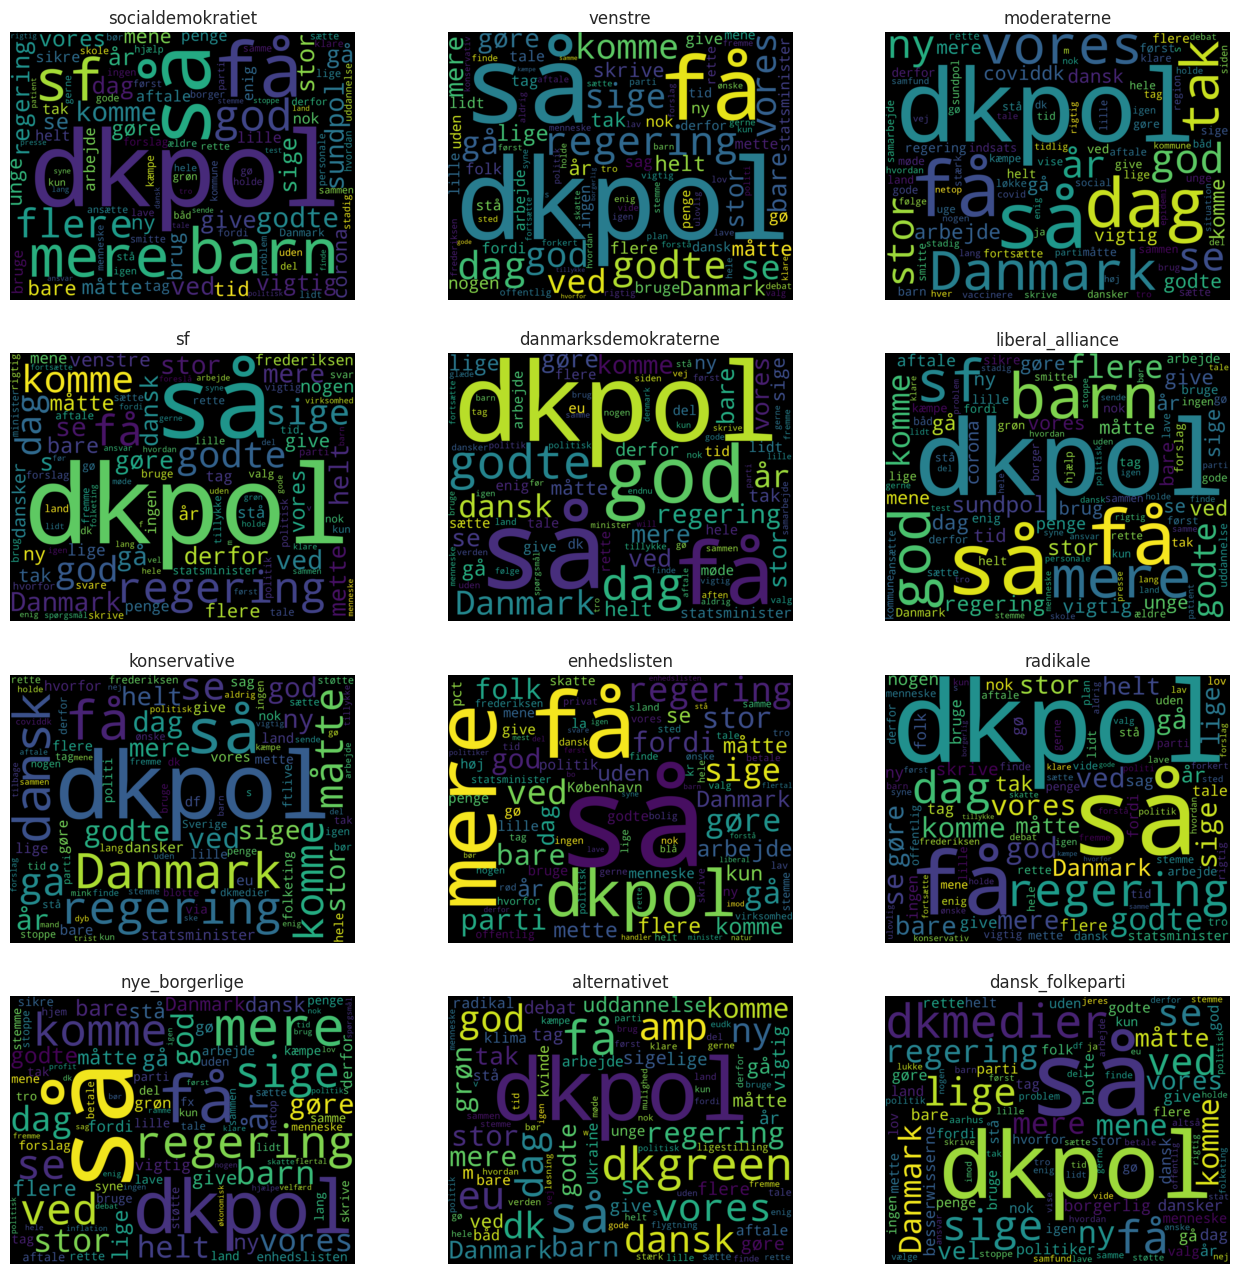

In [ ]:
#Plot formatting

fig, axs = plt.subplots(4, 3,figsize=(16,16))
k=0
for i in range(4):
    for j in range(3):
        axs[i, j].imshow(word_cloud[k], interpolation="bilinear")
        axs[i, j].axis("off")
        axs[i, j].set_title(giant_df.Party.unique()[k])
        k+=1
plt.show()

### SpaCy herunder:

In [ ]:
pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.4.2
    Uninstalling spacy-3.4.2:
ERROR: Could not install packages due to an OSError: [Errno 30] Read-only file system: '/shared-libs/python3.9/py/bin/spacy'

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import spacy
from spacy import displacy
from collections import Counter
import pandas as pd
pd.set_option("max_rows", 400)
pd.set_option("max_colwidth", 400)

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-17 14:21:36.599196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 14:21:36.799698: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 14:21:36.799732: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
202

In [ ]:
!python -m spacy download da_core_news_md

2022-11-17 14:22:04.350847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-17 14:22:04.512967: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-17 14:22:04.513003: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-17 14:22:04.550657: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-17 14:22:05.510433: W tensorflow/stream_executor/pla

In [ ]:
nlp = spacy.load('da_core_news_md')

In [ ]:
nlp.max_length = 150000000

In [ ]:
test_doc = ' '.join(giant_df.CT.iloc[0])
test_doc = nlp(test_doc)
for token in test_doc:
    print(token.lemma_, token.pos_, token.dep_)

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
adjs = []
for token in test_doc:
    if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)

AttributeError: 'str' object has no attribute 'pos_'

In [ ]:
adjs_tally = Counter(adjs)
adjs_tally.most_common(20)


[('god', 403),
 ('stor', 264),
 ('ny', 187),
 ('vigtig', 172),
 ('mange', 164),
 ('sundpol', 136),
 ('hel', 122),
 ('dansk', 111),
 ('godte', 109),
 ('stærk', 100),
 ('gammel', 99),
 ('ung', 96),
 ('klar', 91),
 ('lille', 81),
 ('høj', 79),
 ('lang', 79),
 ('enig', 76),
 ('sidste', 71),
 ('samme', 67),
 ('alvorlig', 61)]

In [ ]:
nouns = []
for token in test_doc:
    if token.pos_ == 'NOUN':
        nouns.append(token.lemma_)

In [ ]:
nouns_tally = Counter(nouns)
nouns_tally.most_common(20)

[('tak', 406),
 ('dag', 358),
 ('år', 234),
 ('arbejde', 170),
 ('indsats', 163),
 ('uge', 133),
 ('region', 122),
 ('land', 103),
 ('epidemi', 102),
 ('barn', 101),
 ('tid', 99),
 ('regering', 96),
 ('samarbejde', 95),
 ('båd', 94),
 ('vaccinere', 89),
 ('del', 85),
 ('sundhed', 85),
 ('aften', 81),
 ('parti', 77),
 ('aftale', 77)]

In [ ]:
from IPython.display import Markdown, display

def find_sentences_with_keyword(keyword, document):
    
    #Iterate through all the sentences in the document and pull out the text of each sentence
    for sentence in document.sents:
        sentence = sentence.text
        
        #Check to see if the keyword is in the sentence (and ignore capitalization by making both lowercase)
        if keyword.lower() in sentence.lower():
            
            #Use the regex library to replace linebreaks and to make the keyword bolded, again ignoring capitalization
            sentence = re.sub('\n', ' ', sentence)
            sentence = re.sub(f"{keyword}", f"**{keyword}**", sentence, flags=re.IGNORECASE)
            
            display(Markdown(sentence))

In [ ]:
find_sentences_with_keyword(keyword="klima", document=test_doc)


diabetes diabetesforeningen afgøre del kamp christiansborg kæmpe sommerferie investere mio diabetesteknologi diabetes sundpol splittelse mere samarbejde dkpol tak samt aftale fritidstillæg mest digital fortskredne land verden agilt privat erhversvliv lægge stor vægt bæredygtighed udgift medicin reel barriere sundhed menneske fjerne brugerbetaling ordinere medicin barn kontanthjælpssystem modtage kontanthjælp år vigtig skridt gø ulighed sundhed ulighedisundhed forklaring stige smitte introduktion ba Danmark undervariant omikron udgøre foreløbig pct bekræfte tilfælde uge ssi følge fortsætte udvikling tætte beregne indikere epidemi begynde stige svag underbygge spildevandsovervågningen se stigning fem region særlig region hovedstad coviddk kl dansk region enig udmøntning mia kr samle fremme herefter mio forstå parti beskytte støjberg kommissionsundersøgelse indtil borgerlig regering trumpudpegede tidlig usaambassadør dk sprede misinformation glad cykle hvilken sund godte miljø **klima** middelklasse råd køre bil Danmark nægte tro ved god fald uge uge periode

tilvalgsordningen vaccinere offentlig høring dag betyde endelig udstedelse næste uge mellemtid gennemføre dialog virksomhed udvise interesse stå opgave så praktisk spørgsmål afklare gennemføre intensivere smitteopsporing b antal ny tilfælde stige vurde situation variant b nordsjælland kende Mexico fylde størstedel epidemi intensivere opsporing ny fund få isolere nære kontakt nære kontakt følge opdatering coviddk milepæl vaccinationsindsatsen hver fjerde dansker påbegynde vaccination kæmpe tak arbejde benhård få vaccine dansker tålmodighed fortsætte arbejde coviddk beregne tyde le stige epidemi Danmark forventelig takt samfund genåbne torsdag åbne endnu mere så lad huske gode råd afstand hygiejne test så genåbning ske forsvarlig tak coviddk uvished vaccinere gø desv vanskelig opdatere vaccinekalender enig væsentlig transparens indkalde parti møde morgen netop vaccinere herunder vaccinationskalender familie gjesing åbne dejlig køkken vores maj morgen holde vores tale team kaffe varme bolle hjemmebag god maj lars forstå godte stor behov afklaring vilkår arbejde ministerium styrelse weekend helligdag bla nyttig melding parti gå enestående indsats så sen dag vurdering foran folketing partileder brug vores forhandling derefter international seminar leve demokratisk debat så stor gavn ekspert løfte opgave gøre klog offentlig underskud mia kr svare bnp eneste euland leve præsentation god kurs nytænke indhold held lykke forhandling resultat forankre brede parti grøn fremtid vores landbrug fuld helt **klima**indsatsen holde faste udrulning risiko alvorlig sygdom ved smitte modtage vaccinere uge begynde hurtig arbejde gennem aldersgruppe utålmodig vige beregne epidemi stabil niveau komme udsving sidste uge genåbning tidlig vise kurve test sekventering opsporing lokale tiltag lille forår vaccine give hjælpe hånd vaccinationsindsats skride fremme dag hver femte dansker påbegynde vaccination hver eneste stik nedsætte risiko alvorlig forløb dødsfald så tak tage imod vaccination coviddk dø stærk overdrive friste sige ja rygte finde derude forlyde kontakttal beregne dermed lykkes fortsætte holde epidemi stabil niveau Danmark gunstig situation give godte afsætte genåbning morgen coviddk hjem vores datter sidde lave fremlæggelse klasse homovielser morgen sidde tjekke hvem folketing stemme imod tilbage dag ekstra glad grøn stemme navn dag stærk hold hele inkl presse unge synes mulig s ny life science strategi land god udvikle ny behandling god forske god patient glæde allesammen dklifescience sundpol fantastisk milepæl dansker få

dkpol klare saltvandsindsprøjtning land sygeplejerskeuddannelse mio lade medarbejder vores sygehus hørt sidste år komme flere flere patient få sygeplejerske hænge sammen derfor sætte så få flere sygeplejerske gennem uddannelse job tak samarbejde tydelig sommerdag sammen underskrive aftale sydhavnsmetroen dag huske beslutning stolt dejlig se arbejde gå fremad mere metro joakim redigere artikel efterfølge så mere ren fokus aktiv dødshjælp hvilken helt relevant god diskussion frederik ja redigere efterfølge handle mere klar aktiv dødshjælp diskussion helt sikker relevant topform nytårsstævne enig uenig godte se tydeligvis respekt argument måde forklare forsvare politik god tradition sammen folketing parti bevilge flere middel netop livslinie så udvide åbningstid reel døgnåben præcis efterspørge kende problem løft psykiatri netop se sammenhæng år plan begynde arbejde komme ske samarbejde interessent måtte trykke præcis opfordring herfra vælge læg spalte forherligelse selvmord så sætte henvisning livslinie telefonrådgivning nederst artikel døgn rund redde liv hilsen aligo år først lørdagsmøde Næstved aligo medlem byråd møde hver måned partifælle kaffe morgenbrød god fri politisk debat hjerte ro afdække livsvigtig sag ord egentlig betydning undersøge afsløre journalistik understrege rolle journalistik stadig vores samfund tak dkpol sundpol dkmedier erik ja altid passe fyrværkeri tre øjenskade år tre kede fremstå hav god aften godte selskab panel aftenshowet sammen rasmus se tweet få rette interesse måtte desværre skuffe se koordinering føre hånd vores tweets egn reaktion måske endda naturlig minister se statsmins nytårstale skrive minut bagefter mønsterbryderne først fremmest bryde mønstre sætning hørt mette frederiksen sige så gang rette tage statsminister først nytårstale fokus svigte barn dkpol holde formidabel nytårstale fokus ensomhed bekæmpe antisemitisme intolerance forene samle folk nation kamp **klima** vores lille blå plan vagt tusind tak jeres indsats no one told you life was gon na be this way samle lego pige jul glæde gode ting ting kæmpe sammen rigtig glædelig jul jul lille arbejde imens holde fri dkpol slappe nyde gode stund vores kære drager medarbejder sygehus plejehjem rund omkring land arbejde jul

diabetes fokus opspore sygdom tidlig tidspunkt diabetes føre alvorlig følgesygdom forebygge sygdom opdage tide diabetesday barre lige hæve topmøde marienborg **klima**partnerskaber fremtid insulin levere uden plastikemballage kæmpe arbejde foran stærk erhvervsliv gribe dagsorden

dkpol opleve massiv opbakning nytænkning toppe dansk erhvervsliv regering ny **klima**partnerskaber tjek så s input huske båd toppe medarbejder medlem gerne dkpol dkgreen oplysning faktisk inden år udgang måtte indrømme ny status tak mikael bruger behandler politiker industri dag bidrage forbedre behandling høret secretary met danish health minister during a visit to copenhagen to see firsthand a range pleased to welcome to copenhagen today we share many common priorities and had a fantastic and inspiring discussion on how to increase healthequity also very fruitful to share views on the brexit process dkpol kalender skub pga rapport styrelse patientsikkerhed parti afvente tankevækkende indlæg så vigtig helt tidlig indsats mulighed uddybe jeres erfaring konkret forslag kop kaffe tak louise sende ro opbakning næsegrus beundring direkte vej

trods tro øvrig ven endomondo følge rute live prøve ramme procent grøn ligesom vores **klima**mål København deltage mere virksomhed erhvervsorganisation sammen amp worldmentalhealthday sætte fokus mental sundhed hele verden

dkpol tale traditionsrig grundlovsarrangent broksø dag først socialdemokrat nogensinde så netop dag valgdag fv lave ting sammen ja nem forklare pige hvordan dansk politik fungere ja lige lille krise tusind tak lige vores hjemmelavet valggrafik føre sammen pige ny måling fv diskutere rest aften måtte foreslå sted læse føre professor kommuneøkonomi konkludere nemlig jeres udspil særlig tilgodese kommune gentofte Frederiksberg lyngbytaarbæk forgylde forvej mest fordi lod la køre økonomisk skattepolitik bla borgmester Horsens tønde odsherred advare imod se feks besparelse skylde løkke regering snyde Assens kommune udligning Assens miste million krone udligning løkke imens løkke sende mia forvej velstillet kommune sted dk skæv fv sidste vælgermøde sammen dejlig engagere skarp elev karise efterskole udviklingshæmmet elev særlig behov **klima** uddannelse Danmark mere plads hinanden forskellighed enmillionstemmer fv lægge land strategi superliga nytte stadion genkomst legendarisk slogan sætte harboe bord Næstved superligasporet tro stor se station

fair transport regel eu fokusere skaffe medlem ordentlig vilkår tak se godte fv bruge tale Karrebæksminde forrest række sidde jens peter tag tur hele vej f skagerak hilse sige stemme ok pokker osse måtte vente spænding rygte sige valgemojis vej lige prøve folketingsvalg valg fv stærk gå dkpol john ja desværre fuld dække bekendt tag direkte svar ministerium ingen heller påvise fejl tal illustrere nedskæring starte dvs vores regeringstid christiansborg måske hele København nedskæringstælleren time time dag derpå tak god samtale dag tilbage masse energi slutspurt dkpol fv høre folketing formand sige **klima**tosser gø rimelig stor øjne ella sige godte resultat **klima** vores fremtid rakel konstatere så måtte held lykke forklare egn barn

anders godte forstå ironi al fredsommelighed måtte sige vist kende område dårlig tro ny cykelstativ enkeltelementer udrydde fuldstændig god ide overveje faktisk vist grønt bevis fødevare gøre så sikre side god weekend john ja lækker is dejlig respons menneske to valg måde kampagne to kryds kede komme forbi is rigtig god valgkamp tale politik travl familie ved supermarked ulvetime tilbud få is isbilen snak politik så ryk valgkampagne superbrugs fensmark tag isbilen enø komme forbi nok vores fælles ansvar bare rigtig nogen finde måtte lade gøre lave god tro theresa may give lige tåre øje afslutning afskedstale dyb ulykkelig situation dyb mangel ansvarlig politiker afslutning tale røre morgenfrisk panel politiker debattere valgkamp stor spørgsmål finansiering velfærd morgenkaffe debat hvordan velfærd finansiere give kommu fejl virkelig sej søde dejlig møde så dedikere reflektere **klima** drøm få lov stå spids fodbold fællesskab gå sy ja desværre nok helt rette politisk debat flere område nødlidende især negativ angribe automatsvar iltfattig gø nogen klog gælde begge side ja tro rette flere sangrebsannoncer ved sidste valg endnu grund valgkamp god mette kende årsag ting blokere heller tænke gøre ift politiker nogen chance vide så blande pæn udenom gerne uden anklage hykleri satans signal debat sej klasse Holbæk tag tur s valgstudie forberede skarp spørgsmål bla

**klima** dkpll fv vide mere burde samle ekspert samle erfaring udland mm lave plan helt enig helt åbenlys organisere systematisk virke indsats opklare optrevle samme mens tvinge lappe cyklus evighed michael ja rette forbehold god dag kirsten forstå tage folketing samle valg så sidste smøg skod christiansborg enig michael ja få humør tilbage god mulighed måtte skønt præcis samme måde bare lige modsætte faktisk Næstved gi kr år netop fordi få stjæle så så nå enkelt aften så stjæle arghh helv osse mens ude valgkampagne cykel stjæle Næstved station cykelhjelm kast tag elske cyklus hade cykeltyveri rigtig cykel fred dsbstation dkpol fv aften vildt god oplevelse ring få snak hjemme kim majbritt Næstved egentlig lav frikadelle ringe pizza få snak politik så søde møde dkpol fv delvis traumatisk forhold især pga utallig dsuaftener gigantisk familiepizzaer skinkestrimler ananas dag løsne mere nok især fordi datter elske få andel selskabsskat temmelig komplicere system snitte få kommune ca pct selskabsskat indbetale le sige skyld politisk uenighed se s læg stemme al stilfærdighed konkludere jeres parlamentarisk grundlag heller direkte imponere målrette pille mest ulighedsskabende tidsel regering udspil gøre klar start hvilken element jeres udspil ren lapolitik derfor gøre forlig umulig derfor hverken s læg stemme så asocial skæve reform belønne få velstillet kommune fuldstændig trække tæppe vække presse kommune tråd slutte lt regering udspil få professor kommunaløkonomi kurt houlberg konkludere se umiddelbar stor lydhørhed argument kommune borgmester samme partifarve regeringsparti gt baggrund jyllandsposten konkludere velstillet borgerlig kommune rudersdal gentofte stor vinder regering komme igennem udspil gt endelig regering nedsætte grænse velstillet kommune betale udligning fattig kommune endnu omvende robin hood gt regering lever ekstra stor gave mest velstillet kommune nedsætte udligning selskabsskat målrette betragtelig millionindsprøjtning mest velstillet kommune få postnummer gt omvende regering position kommumer så velstillet råd sænke skatte tildele bonus finansiere kommune gt økonomisk overgangsordning ifølge regering pct afhængig enkelt kommune skatteprocent kommune forhøje skatte overgansordningen herefter bortfalde regering krav gt del forhandling udligning derfor gerne bidrage faktum hvorfor s læg stemme regering udspil skæv favorisere velhavende kommune straffe økonomisk udfordre gt frberg måske lige lovlig lang holde deromkring udkant politiker borger følelse sjov oplevelse ring politisk pizzabud sætte aften igen besøge så vælger mulig bestille pizza komme gi pizza give lov komme politisk peptalk fv sige grund lykkes lave udligningsreform s bide bolle dække regering foreslå skæve reform straf kommune vanskelig økonomi give bonus rige kommune råd skattelettelse fv torben finn tro spor sovjet dansk socialdemokrat tværtimod følge fordi ofte interessant gode pointer sjælden socialdemokratisk lige hav

sammen Danmark gå foran forandre verden sammen ivoteglobalgoals fv ja tro american modern family phil dunphy engang jakkesæt skjorte europæisk snitte sidde rimelig stram falde god jord opleve måske nok lidt vanskelig lade samtale påvirke kamera ly mm syne koncept fungere duel god skarp leve mette f hjemmebane direkte samtale engagere borger stærk format dkpol fv datter holde oplæg **klima**forandring drivhuseffekt morgen skole not dkgreen skolechat formidabel initiativ Odense dag få masse gode snakke gøre kolleger parti vores demokrati befolkning lyst deltage lang god form måske tro valgfolkemøde fv dkpol hjerter endnu varm kaffe stor ære give hjælpe hånd kaffeboden tvs folkemøde vist godte trick møde rigtig menneske tak teamwork dkpol fv ep kompol kamp lille utrolig tætte race spørgsmål politisk historie ja rød hold vinde sidst folkemødepåtv fv dkpol vinde

lige alting quizze valgfolkemøde socialdemokrat regeringsmagt mål lille pct co reduktion ift central del ny styrke dansk **klima**lov

først friaften valgkamp tradition tro komme så Danmark drgrandprix escdk lov signal udskifte uanset hvilken regering få gammel erne stå imod halvdel banedanmarkrelaterede forsinkelse hver ting tid helt traditionel husstandsomdeling gå dørtildør intet politik fungere finte så lige ramme situation brug klappe skulder god togdrift chokoladebolle glad socialdemokrat morgen dele Næstved station oversigt læst seks time siden guld referere lige komme hjem paneldebat hovedangrebspunktet modstander kalde **klima**hysteri fabriksgulvet interviewe ren christensen df handler virksomhed peter ja rette stemme eneste få sekund opmærksomhed så måtte vurdere bagefter enig sætte få tælle ellers møde traditionel kampagne tirsdag burde tjek sige vanskelig indkredse helt specifik ift geografi måtte lige høre igen tusind tak info hjælpsom lige lange transport pizza hyggelig lige stoppe aften gi tippe næste virkelig sjov ude tak mette hav god aften så vist ændre storkreds først nok tii knibe storkreds ved kører politisk pizzabud prøve regel bestille komme pizza betale si ja få sekund politisk peptalk dagligstue samtidig tak pyramide pizzeria kende hele Næstved fv enig fede opdage efterhånden farhjerte smelte lige opdage vores teenagedatter lav liv playliste vælge sebastian tre først håbe jinxer hele dkmusik lytte podcasten udfordre fire politiker blaffe først afsnit fv dkpo komme hjem lange møde valgkamp så brug friske luft klare hjerne så verden dejlig hustru sparringspartner tag aftenløbetur skov fv tak michael palle direktør palle fragt tale socialdemokrat vognmand udfordring bla

lige gammel datter morgen ok gå **klima** to time dag ja stolt ok ved lige vores klasse tale lige **klima**strejke tak pia lige måde savne vores transportpolitisk samarbejde gå mention the war nanna kæmpe få nedsætte pulje kompensere netop vucerne få elev lykkes få afsætte mio gerne høj nok omprioriteringsbidraget barber forklaring hjemme roligvedsvej siden august indrømme hold lidt kaliber møde control slide sjællandsk stadion vente år storkamp gi stadion svoger aabfan skrive ha blir eneste få gratis aften sydbankpokalen næver få politisk kolleger plusse tag ansvar samfund værdi vanskelig situation tak samarbejde metro mest kritisk fas jørgen glenthøj kompoldk dkpol fjerneste indsigt uddannelsesområde forestille yderområderne mere brug ungdomsudda regering nedskæring uddannelse lukke vuc by katastrofe vores yderområder stoppe nedskæring vores fremtid tænke dkpol uddpol dkibalance lige måde kim kreds aften genvælge partiforening Næstved nordvest folketingskandidat tusind tak tillid medlem gøre god leve dkpol omstilling komme vente løbe tid derfor udspil s hele dks elforbrug dække vedvare energi foreslå Danmark opføre yderlig stor havvindmølleparker komme årti dkgreen dkpol tak fuldkommen utrolig så sen regne mystisk måtte indrømme så godte lide siden dokumentar virke gennemføre ordentlig menneske ja vildt ufattelig ved hvornår sidste bøde udskrive overtræde forbud danse mellem mand forbyde indtil føde far langhåret gå islændersweater mor page lilla tøj engang flippe stå forbyde mand danse sammen indtil forstå intet mene social medie styrke demokratisk samtale fordi diskutere indhold argumentere prøve forstå hinanden synspunkt hvorfor nogen gang mene samme medie skade samme samtale se nedenfor helt ærlig minde inklusive ligesom sidste gang radikales stor indflydelse thorningregeringernes økonomisk politik bekendt føre uendelig dyr skattestigning kære søren måske holde inde skræmmekampagne gø godte politisk samtale fuldkommen utrolig række næver få lidt ufortjent Silkeborg så vinde hvidovre lige Viborg hold samme antal point sæson slutte børge tak spørgsmål transportordfører forhandle område ved trafiksikkerhed mærkesag konkret spørgsmål skrive feminist udsagn passe direktørhustru vist god marts womensday heunicke s blik rør formand henrik w petersen møde studium snakke dårlig inde**klima** bryde enkelt kæmpe imod fastlåse struktur sætte dkmedier lov skrive forbedring slags megaprojekter dk underkaste kritisk ly tåle aktiv kritisk presse hensyn samle billede notere forbedring ren faktisk lykkes

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30797f9c-952e-45b4-98d4-31c9ac73ae78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>